In [1]:
import numpy as np
import pickle
from annoyforest import Annoy
import time
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import pandas as pd

Итак, алгоритм annoy написан следующим образом. Рекурсивно, делением пространства случайными гиперплоскостями строятся деревья. Деление продолжается до тех пор, пока в ноде будет не более заданного числа объектов(параметр алгоритма). Случайные гиперплоскости выбираются так: выбираются два объекта из попавших в ноду. Плоскость - это множество точек на равном расстоянии от объектов. Таким образом, плоскость задается двумя интами(индексами объектов). Таких деревьев создается несколько(параметр). Поиск происходит следующим образом. Корни деревьев скалдываются в кучу, потом из кучи извлекается нода, ее потомки складываются в кучу. Если очередная нода листовая, то объекты из нее складываются в множество. В качестве приоритета для кучи - расстояние от объекта до плоскости, заданной в ноде. Расстояние умножено на знак в зависимости от стороны, с которой находится объект. Мы извлекаем ноды до тех пор, пока не наберем нужное число объектов в ноде(третий параметр). При использовании кучи, мы работаем в первую очередь с деревьями, которые дальше отделяют от искомого объекта. Когда ноды с положительным отступом заканчиваются, мы можем рассмотреть ноды с отрицательным отступом (те, от которых мы отделили плоскостями). При этом в певую очередь будут рассмотрены те, которые отделились ближе всего к объекту.

После открытия нужного числа листовых нод, объекты ищутся в множестве линейным поиском.

In [2]:
def get_euclidean_scores(sample, embeddings):
    if len(embeddings.shape) == 2:
        return np.sqrt(((embeddings - sample) ** 2).sum(axis=1))
    return np.sqrt(((embeddings - sample) ** 2).sum())

def get_nn_brute(emb, embeddings, n_neighbors):
    scores = get_euclidean_scores(emb, embeddings)
    args = np.argsort(scores)
    return args[:n_neighbors]

Проведем исследование написанного алгоритма. В качестве метрики качества посчитаем следующее. Возьмем первые n объектов выдачи, посчитаем мощность пересечения ее с напрямую посчитанной выдачей, поделим на n. Усредним метрику для поиска нескольких случайных объектов. Проведем эксперименты на эмбеддингах изображений. У алгоритма три влияющих параметра: число деревьев, максимальное число объектов в ноде, число объектов, которые мы ищем при помощи алгоритма. Будем перебирать все три по сеткам. 

In [3]:
def quality_metric(true, predicted):
    return len(set(true).intersection(set(predicted))) / len(true)

def estimate_model(model, embeddings, n_neighbors, n_search, n_cycles):
    times = []
    metrics = []
    for _ in range(n_cycles):
        idx = np.random.randint(0, len(embeddings))
        t = time.time()
        predicted = model.find(embeddings[idx], n_search)[:n_neighbors]
        times.append(time.time() - t)
        true = get_nn_brute(embeddings[idx], embeddings, n_neighbors)
        metrics.append(quality_metric(true, predicted))
    return np.array(times).mean(), np.array(metrics).mean()

In [4]:
embs = pickle.load(open('../../embeddings', 'rb'))

In [5]:
embs = embs.astype(float)

In [7]:
n_trees = [8, 16, 32, 64, 128]
node_sizes = [10, 20, 40, 80, 120, 160, 200, 300, 400]
n_search = list(range(50, 2050, 100))
times = defaultdict(lambda: defaultdict(list))
qualities = defaultdict(lambda: defaultdict(list))
for n_tr in n_trees:
    for ns in node_sizes:
        print(ns, n_tr, flush=True)
        model = Annoy(ns, n_tr)
        model.fit(embs)
        for nse in tqdm.tqdm(n_search):
            tim, quality = estimate_model(model, embs, 50, nse, 50)
            times[n_tr][ns].append(tim)
            qualities[n_tr][ns].append(quality)

10 8



  5%|▌         | 1/20 [00:06<01:56,  6.11s/it]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vch/py3/lib/python3.5/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vch/py3/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 20/20 [02:06<00:00,  6.31s/it]

20 8



  0%|          | 0/20 [00:00<?, ?it/s]


KeyboardInterrupt: 

Очевидно, что при увеличении числа собираемых объектов, увеличивается качество и время. Будем строить кривые качества от времени для различного числа объектов в ноде.

Text(0,0.5,'quality')

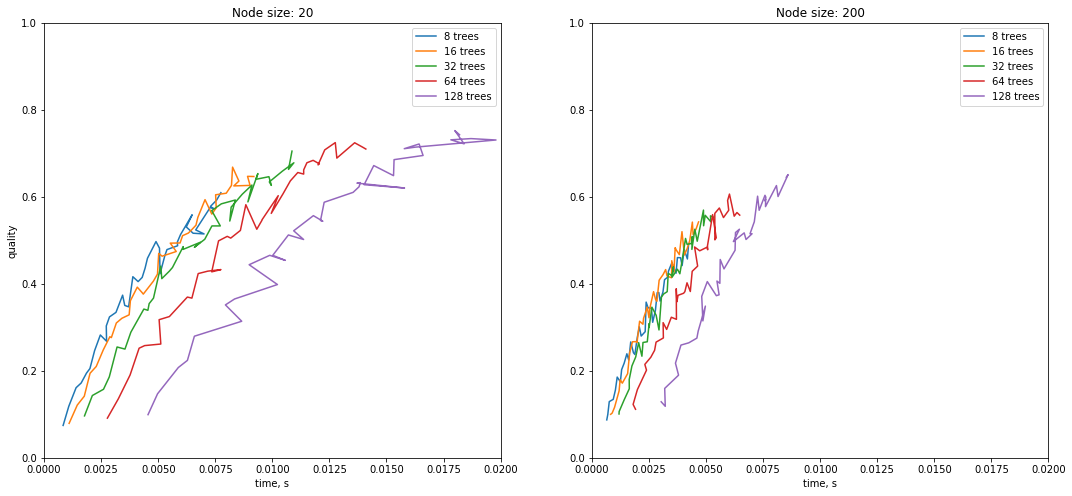

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
for nt in n_trees:
    ax[0].plot(times[nt][20], qualities[nt][20])
    ax[1].plot(times[nt][200], qualities[nt][200])
ax[0].legend(['{} trees'.format(nt) for nt in n_trees])
ax[1].legend(['{} trees'.format(nt) for nt in n_trees])
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)
ax[0].set_xlim(0, 0.02)
ax[1].set_xlim(0, 0.02)
ax[0].set_title('Node size: 20')
ax[1].set_title('Node size: 200')
ax[0].set_xlabel('time, s')
ax[1].set_xlabel('time, s')
ax[0].set_ylabel('quality')
ax[0].set_ylabel('quality')

Text(0,0.5,'quality')

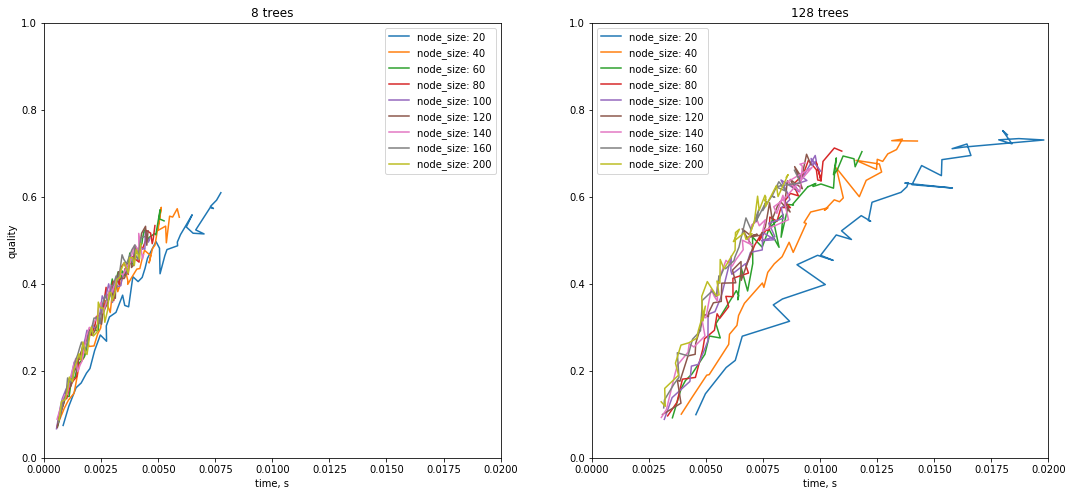

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
for ns in node_sizes:
    ax[0].plot(times[8][ns], qualities[8][ns])
    ax[1].plot(times[128][ns], qualities[128][ns])
ax[0].legend(['node_size: {}'.format(ns) for ns in node_sizes])
ax[1].legend(['node_size: {}'.format(ns) for ns in node_sizes])
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)
ax[0].set_xlim(0, 0.02)
ax[1].set_xlim(0, 0.02)
ax[0].set_title('8 trees')
ax[1].set_title('128 trees')
ax[0].set_xlabel('time, s')
ax[1].set_xlabel('time, s')
ax[0].set_ylabel('quality')
ax[0].set_ylabel('quality')

Видим, что с возрастанием числа деревьев и с уменьшением размера ноды растет время работы и качество результата. Можем выбрать порог по времени работы и найти параметры для наилучшего качества.

In [43]:
time_limit = 0.002
best_pars = None
best_quality = 0
for nt in n_trees:
    for ns in node_sizes:
        for nse in range(len(n_search)):
            if times[nt][ns][nse] < time_limit and qualities[nt][ns][nse] > best_quality:
                best_quality = qualities[nt][ns][nse]
                best_pars = (nt, ns, n_search[nse])

In [44]:
best_pars, best_quality

((8, 140, 700), 0.3)

In [45]:
timesarr = np.array([times[nt][ns][idx] for nt in n_trees
                    for ns in node_sizes for idx in range(len(n_search))])
qualitiesarr = np.array([qualities[nt][ns][idx] for nt in n_trees
                    for ns in node_sizes for idx in range(len(n_search))])

In [46]:
pickle.dump(timesarr, open('times', 'wb'))
pickle.dump(qualitiesarr, open('qualities', 'wb'))

Text(0,0.5,'quality')

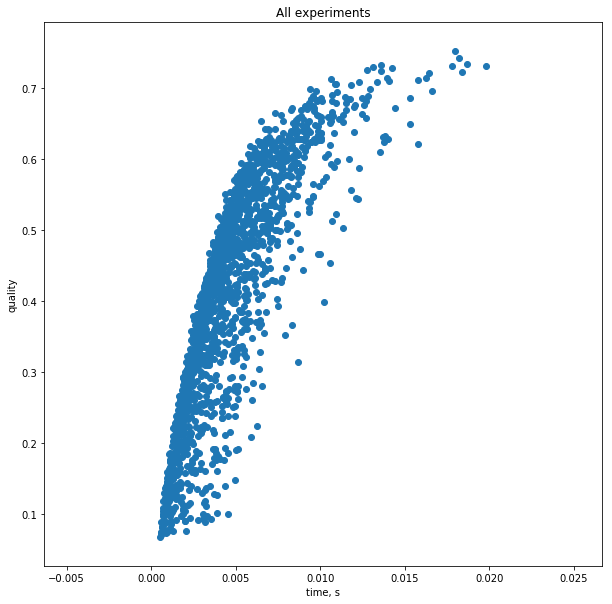

In [50]:
plt.figure(figsize=(10, 10))
plt.scatter(timesarr, qualitiesarr)
plt.title('All experiments')
plt.xlabel('time, s')
plt.ylabel('quality')